In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns

## Load Data

In [531]:
path = '/Users/ridleyleisy/Documents/lambda/unit_two/DS-Unit-2-Classification-1/ds4-predictive-modeling-challenge/'

In [532]:
train = pd.read_csv(path + 'train_features.csv')
test = pd.read_csv(path + 'test_features.csv')
labels = pd.read_csv(path + 'train_labels.csv')
sample_submission = pd.read_csv('https://drive.google.com/uc?export=download&id=1kfJewnmhowpUo381oSn3XqsQ6Eto23XV')

## clean data

### numeric

In [533]:
def drop_cols_rows(df):
    df.drop('num_private',axis=1,inplace=True)
    df.drop('recorded_by',axis=1,inplace=True)
    return df

In [534]:
train = drop_cols_rows(train)

#### replace longitude

In [535]:
#test whether you want to keep longitude
long_mean = train.loc[train['longitude'] !=0]['longitude'].mean()
train['longitude'].replace(0,long_mean,inplace=True)
test['longitude'].replace(0,long_mean,inplace=True)

#### drop longitude

In [414]:
#test whether you want to drop longitude from dataset
train = train.loc[train['longitude'] != 0]
test = test.loc[test['longitude'] != 0]

## Train construction year data

### feature engineering

In [536]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns

#### construction year predicted by random forest

In [537]:
train['construction_year'] = train['construction_year'].replace(0,np.nan)
test['construction_year'] = test['construction_year'].replace(0,np.nan)

In [538]:
def transform_construction(df):
    
    df = df.select_dtypes(include=np.number)
    X = df.loc[~df['construction_year'].isna()]
    
    # can only use these featuers since they differ 
    features = ['amount_tsh', 'gps_height', 'longitude', 'latitude',
       'region_code', 'district_code', 'population']
    target = 'construction_year'
    
    X_train = X[features]
    y_train = X[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X_train,y_train)
    m = RandomForestRegressor(n_estimators=20,max_depth=25)
    m.fit(X_train, y_train)
    
    vals = m.predict(df.loc[df['construction_year'].isna()][features])
    
    return  vals

In [539]:
train.loc[train['construction_year'].isna(),'construction_year'] = transform_construction(train)
test.loc[test['construction_year'].isna(),'construction_year'] = transform_construction(test)
train['construction_year'] = round(train['construction_year'])
test['construction_year'] = round(test['construction_year'])

#### construction year based on distribution

In [540]:
# getting distributions for construction years
dist = train['construction_year'].value_counts(normalize=True)
dist_test = test['construction_year'].value_counts(normalize=True)

In [541]:
# applying distribution of construction year to na values for train and test sets
train.loc[train['construction_year'].isna(),'construction_year'] = np.random.choice(dist.index, size=train['construction_year'].isna().sum(),p=dist.values)

In [542]:
test.loc[test['construction_year'].isna(),'construction_year'] = np.random.choice(dist_test.index, size=test['construction_year'].isna().sum(),p=dist_test.values)

Add time since construction

In [543]:
def add_construction_diff(df):
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['construction_year'] = pd.to_datetime(df['construction_year'],format="%Y")
    df['time_since_construction'] = (df['date_recorded'] - df['construction_year']).dt.days
    df.loc[df['time_since_construction'] < 0,'time_since_construction'] = 0    
    df['construction_year'] = df['construction_year'].dt.year
    return df

In [544]:
test = add_construction_diff(test)
train = add_construction_diff(train)

Feature engineering

In [564]:
def add_ratios(df):
    df['tsh_by_longitude'] = df['amount_tsh'] / df['longitude']
    df['tsh_by_latitude'] = df['amount_tsh'] / abs(df['latitude'])
    df['tsh_by_height'] =  df['amount_tsh'] / df['gps_height']
    df['tsh_by_height'] = df['tsh_by_height'].replace(np.inf,0).replace(np.nan,0)
    return df

In [565]:
test = add_ratios(test)
train = add_ratios(train)

### reduce label size to fit feature engineers

In [566]:
labels = labels.merge(train,on='id')[['id','status_group']]

## Encoding and Scaling Categorical Data

In [568]:
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [569]:
unique = train.describe(exclude=np.number).T.sort_values(by='unique')

In [570]:
cat_features = list(unique.loc[unique['unique'] < 130].index)

In [571]:
numeric_features = list(train.describe().columns[1:])

In [572]:
encode_features = cat_features
features = numeric_features + encode_features

### Pipeline

In [597]:
def transform_data_hot(features):
    encoder = ce.OneHotEncoder(use_cat_names=True)
    scaler = RobustScaler()
    X_train = train[features]
    y_train = labels['status_group']

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, train_size=0.80, test_size=0.20, 
        stratify=y_train, random_state=42)

    X_train_sub = X_train[features]
    X_val_sub = X_val[features]
    
    pipeline1 = Pipeline([('encoder',encoder),('scaler',scaler)])
    X_train_sub_encoded = pipeline1.fit_transform(X_train_sub)
    X_val_sub_encoded = pipeline1.transform(X_val_sub)
    
    test_encoded = pipeline1.transform(test[features])
    X_encode_cols = encoder.transform(X_train_sub)
    
    return X_train_sub_encoded, X_val_sub_encoded, y_train, y_val, X_encode_cols,test_encoded

In [555]:
def transform_data_ordinal(features):
    encoder = ce.OrdinalEncoder()
    scaler = RobustScaler()
    X_train = train[features]
    y_train = labels['status_group']

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, train_size=0.80, test_size=0.20, 
        stratify=y_train, random_state=42)

    X_train_sub = X_train[features]
    X_val_sub = X_val[features]
    
    pipeline1 = Pipeline([('encoder',encoder),('scaler',scaler)])
    X_train_sub_encoded = pipeline1.fit_transform(X_train_sub)
    X_val_sub_encoded = pipeline1.transform(X_val_sub)
    
    X_encode_cols = encoder.transform(X_train_sub)
    return X_train_sub_encoded, X_val_sub_encoded, y_train, y_val, X_encode_cols

## Logistical Regression

In [48]:
#model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
#model.fit(X_train_scaled, y_train)

In [ ]:
model.score(X_val_scaled,y_val)

## Decision Tree

In [389]:
from sklearn.tree import DecisionTreeClassifier

In [390]:
m = DecisionTreeClassifier(max_depth=25)

In [798]:
m.fit(X_train_scaled,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [799]:
m.score(X_val_scaled,y_val)

0.8071548821548822

In [800]:
m.score(X_train_scaled,y_train)

0.9867424242424242

In [394]:
pd.DataFrame(m.feature_importances_,X_train_sub_encoded.columns).sort_values(by=0).tail(10)

,0
district_code,0.010797
waterpoint_type_communal standpipe multiple,0.021741
amount_tsh,0.025102
population,0.040552
gps_height,0.053927
waterpoint_type_group_other,0.082631
time_since_construction,0.095104
latitude,0.115097
longitude,0.128420
quantity_group_dry,0.151526


## Random Forest

In [190]:
from sklearn.ensemble import RandomForestClassifier

### ordinal

In [198]:
all_cats = train.describe(exclude='number').T.sort_values(by='unique').index

In [208]:
all_cats = all_cats.delete(all_cats.get_loc('date_recorded'))

In [213]:
X_train_sub_encoded, X_val_sub_encoded, y_train, y_val = transform_data_ordinal(features)

### hot encoded

In [627]:
X_train_sub_encoded, X_val_sub_encoded, y_train, y_val,cols, test_encoded = transform_data_hot(features)

### model

In [694]:
m = RandomForestClassifier(n_estimators=300,max_depth=28,max_features='auto',n_jobs=-1)

In [695]:
m.fit(X_train_sub_encoded,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [696]:
m.score(X_val_sub_encoded,y_val)

0.8111111111111111

In [697]:
m.score(X_train_sub_encoded,y_train)

0.9824074074074074

In [581]:
pd.DataFrame(m.feature_importances_,cols.columns).sort_values(by=0)

,0
extraction_type_class_-1,0.000000e+00
waterpoint_type_group_-1,0.000000e+00
quantity_-1,0.000000e+00
payment_type_-1,0.000000e+00
source_type_-1,0.000000e+00
payment_-1,0.000000e+00
quantity_group_-1,0.000000e+00
waterpoint_type_-1,0.000000e+00
water_quality_-1,0.000000e+00
basin_-1,0.000000e+00


In [698]:
preds = m.predict(test_encoded)

## Gradient Boosting

In [73]:
gbc.score(X_val_sub_encoded,y_val)

0.7553030303030303

In [74]:
gbc.score(X_train_sub_encoded,y_train)

0.7596170033670033

## Reduce Dimensions

In [93]:
feat_impt = pd.DataFrame(m.feature_importances_,encoded_cols).sort_values(by=0)

In [94]:
feat_impt[::-1]

,0
longitude,0.103512
latitude,0.103494
time_since_construction,0.088154
gps_height,0.056625
quantity_dry,0.043583
population,0.041037
quantity_group_dry,0.038667
waterpoint_type_other,0.018375
amount_tsh,0.017356
quantity_group_enough,0.015435


In [95]:
cuml = np.cumsum(feat_impt[::-1])

In [183]:
(cuml.loc[cuml[0] < .95]).head()

,0
longitude,0.103512
latitude,0.207006
time_since_construction,0.295160
gps_height,0.351785
quantity_dry,0.395368


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 9 Text xticklabel objects>)

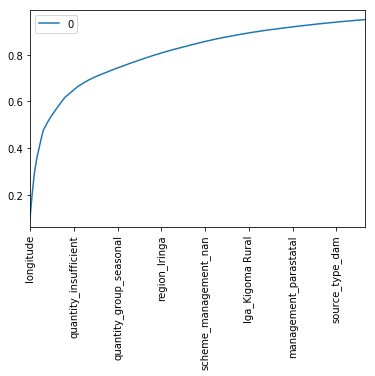

In [97]:
cuml.loc[cuml[0] < .95].plot()
plt.xticks(rotation=90)

In [98]:
reduced_features = cuml.loc[cuml[0] < .95].index

In [99]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage',
       'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'time_since_construction'],
      dtype='object')

### Random Forest Reduced Dims

## Predicting for Kaggle

In [699]:
submission = pd.DataFrame(test['id'])

In [700]:
submission['status_group'] = preds

In [702]:
submission.to_csv('submission-01.csv',index=False)

In [703]:
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

submissions = (pd.read_csv(file)[['status_group']] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)